Includes:

In [1]:
%reload_ext autoreload
%autoreload 2

import seaborn as sn
import os
import matplotlib.pyplot as plt
from data_paths import get_file_paths_ordered
from pre_process import *
from models import *

Number of speakers and the percentage of the available samples to use to consider:

In [5]:
MODEL_NAME = '8speakers'

CSV_DIR = 'csv/'
MODEL_DIR = 'Models/'+ f'{MODEL_NAME}/'
print(MODEL_DIR)
if not os.path.exists(MODEL_DIR):
    print("Creating directory for model : ", MODEL_NAME)
    os.makedirs(MODEL_DIR)

TFLITE_MODEL_NAME = 'tflite_'+ MODEL_NAME
C_MODEL_NAME = MODEL_NAME
print("Model names : ", MODEL_NAME,TFLITE_MODEL_NAME, C_MODEL_NAME)


# Number of speakers and the percentage of the available samples to use to consider:
num_speakers = 8
dataset_percentage = 1 # 0.85
print("Number of speakers : ", NB_SPEAKERS)

Models/8speakers/
Model names :  8speakers tflite_8speakers 8speakers
Number of speakers :  8


Read data:

Total number of speakers in the original dataset: 20
Original number of files per speaker :  [1002, 656, 589, 570, 489, 476, 468, 426]
Training number of files per speaker :  3180


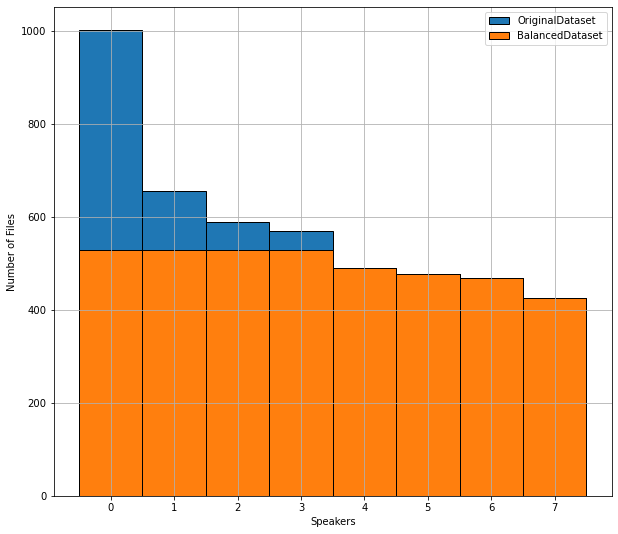

Visualization of the samples ...


100%|████████████████████████████████████████████████████████████████████████████| 3975/3975 [00:00<00:00, 6003.05it/s]


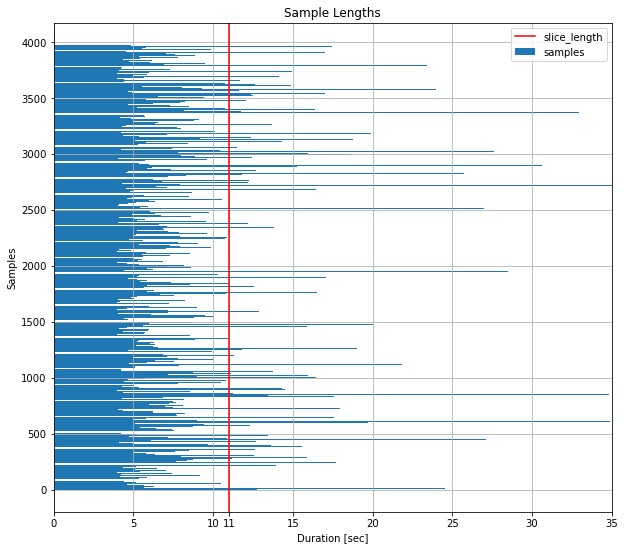

100%|███████████████████████████████████████████████████████████████████████████████| 795/795 [00:02<00:00, 316.20it/s]


In [10]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l = \
    get_file_paths_ordered(num_speaker=num_speakers, test_ratio=0.2, balanced_dataset=True, plot_data=True)

slice_len = choose_tot_slice_len(paths=all_paths_l, visualize=True)

f_s, x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                         y_train_l=y_train_l, y_test_l=y_test_l,
                                                         tot_slice_len=slice_len,
                                                         used_train_sz_rat=dataset_percentage, 
                                                         used_test_sz_rat=1.,
                                                         segmentLength=segmentLength)

@TODO play some of the speakers as an example

Pre-Processing:

In [11]:
f_low=80.
f_up=7600.
num_mel_bins=80
num_mfcc=13
segmentLength=1024

x_train_mfcc = compute_mfccs(x_train, frame_length=segmentLength, sample_rate=f_s, 
                             lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                             num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)
x_test_mfcc  = compute_mfccs(x_test, frame_length=segmentLength, sample_rate=f_s, 
                             lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                             num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)

# Model:

In [24]:
train_set = x_train_mfcc
test_set = x_test_mfcc
print(train_set.shape)

(3180, 171, 13, 1)


In [35]:
model_idx = 0
input_shape = train_set.shape
model = get_model(input_shape=input_shape, nb_classes=num_speakers, model_idx=model_idx)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (3180, 171, 13, 1)       3         
 tion)                                                           
                                                                 
 conv2d_33 (Conv2D)          (3180, 171, 13, 3)        30        
                                                                 
 batch_normalization_33 (Bat  (3180, 171, 13, 3)       12        
 chNormalization)                                                
                                                                 
 activation_47 (Activation)  (3180, 171, 13, 3)        0         
                                                                 
 conv2d_34 (Conv2D)          (3180, 86, 7, 16)         448       
                                                                 
 batch_normalization_34 (Bat  (3180, 86, 7, 16)      

Define learning parameters:

In [36]:
batchSize = 32 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 100 #40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

Compile the model and Fit the Data:

In [37]:
from tensorflow import keras

model.compile(
    loss=loss_fct, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_DIR + MODEL_NAME + '_best.h5',save_best_only=True),
    #keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=1.0e-5),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),       
]

In [38]:
history_keras = model.fit(x=train_set, 
                          y=y_train, 
                          batch_size=batchSize, 
                          epochs=epochs, 
                          validation_split=0.2,
                          callbacks = callbacks, )

Epoch 1/100
80/80 [==============================] - 3s 24ms/step - loss: 1.8036 - accuracy: 0.3416 - val_loss: 2.0722 - val_accuracy: 0.2091
Epoch 2/100
80/80 [==============================] - 2s 21ms/step - loss: 1.1861 - accuracy: 0.6069 - val_loss: 2.5458 - val_accuracy: 0.1352
Epoch 3/100
80/80 [==============================] - 2s 21ms/step - loss: 0.8043 - accuracy: 0.7567 - val_loss: 5.1253 - val_accuracy: 0.1242
Epoch 4/100
80/80 [==============================] - 2s 21ms/step - loss: 0.5375 - accuracy: 0.8408 - val_loss: 4.4765 - val_accuracy: 0.2044
Epoch 5/100
80/80 [==============================] - 2s 21ms/step - loss: 0.4267 - accuracy: 0.8766 - val_loss: 4.3461 - val_accuracy: 0.2610
Epoch 6/100
80/80 [==============================] - 2s 22ms/step - loss: 0.3302 - accuracy: 0.8966 - val_loss: 1.4751 - val_accuracy: 0.5629
Epoch 7/100
80/80 [==============================] - 2s 21ms/step - loss: 0.2628 - accuracy: 0.9175 - val_loss: 0.6900 - val_accuracy: 0.7814
Epoch 

Evaluate the performance on the test set:

In [39]:
y_pred = model.predict(test_set)

test_loss, test_acc = model.evaluate(test_set,  y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

25/25 [==============================] - 0s 7ms/step
25/25 - 0s - loss: 0.3111 - accuracy: 0.9157 - 152ms/epoch - 6ms/step
Test accuracy: 0.9157232642173767
Test loss: 0.3110876679420471


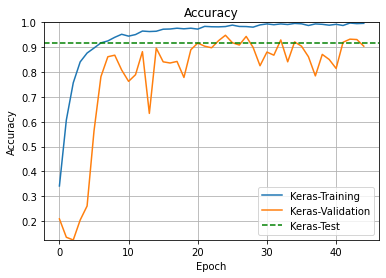

In [40]:
plt.figure()
plt.plot(history_keras.history['accuracy'], label='Keras-Training')
plt.plot(history_keras.history['val_accuracy'], label='Keras-Validation')
plt.axhline(y=test_acc, xmin=0, xmax=epochs, linestyle='--', color='g', label='Keras-Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([1/num_speakers, 1])
plt.legend(loc='lower right')
plt.grid()
plt.title("Accuracy")
plt.show()


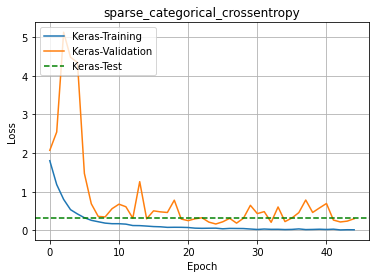

In [41]:
plt.figure()
plt.plot(history_keras.history['loss'], label='Keras-Training')
plt.plot(history_keras.history['val_loss'], label='Keras-Validation')
plt.axhline(y=test_loss, xmin=0, xmax=epochs, linestyle='--', color='g', label='Keras-Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([1/num_speakers, 1])
plt.legend(loc='upper left')
plt.grid()
plt.title(loss_fct)
plt.show()

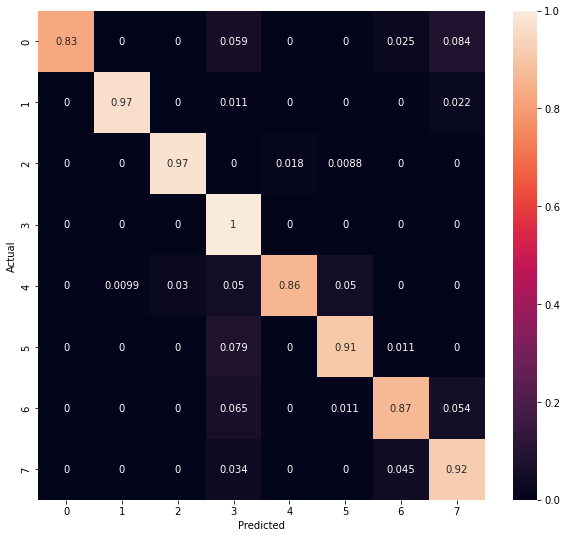

In [42]:
from sklearn.metrics import confusion_matrix

y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Saving parameters

In [43]:
path = MODEL_DIR + f'{MODEL_NAME}/'
print(path)
if not os.path.exists(path):
    print("Creating directory for model : ", MODEL_NAME)
    os.makedirs(path)
    
model.save(path + MODEL_NAME + '.h5')

Models/8speakers/8speakers/
Creating directory for model :  8speakers


In [44]:
# Show the model size for the non-quantized HDF5 model
h5_in_kb = os.path.getsize(MODEL_DIR + MODEL_NAME + '.h5') / 1024
print("Unquantized model file : ", MODEL_DIR + MODEL_NAME + '.h5')
print("HDF5 Model size without quantization: %d KB" % h5_in_kb)

Unquantized model file :  Models/8speakers/8speakers.h5
HDF5 Model size without quantization: 326 KB


# TF Lite Conversion and Quantization:

In [31]:
print(train_set.numpy().shape)

(3180, 171, 13, 1)


In [46]:
import tf_lite_conversion
tflite_model = tf_lite_conversion.convert_to_tflite(train_set,model,MODEL_DIR + TFLITE_MODEL_NAME)

INFO:tensorflow:Assets written to: C:\Users\erolland\AppData\Local\Temp\tmph7smmyta\assets


INFO:tensorflow:Assets written to: C:\Users\erolland\AppData\Local\Temp\tmph7smmyta\assets
C:\Apps\Anaconda3\envs\ml\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [47]:
# Show the model size for the non-quantized TFLite model
# Show the model size for the non-quantized HDF5 model
h5_in_kb = os.path.getsize(MODEL_DIR + MODEL_NAME + '.h5') / 1024
print("Unquantized model file : ", MODEL_DIR + MODEL_NAME + '.h5')
print("HDF5 Model size without quantization: %d KB" % h5_in_kb)

tflite_quant_in_kb = os.path.getsize(MODEL_DIR + TFLITE_MODEL_NAME + '.tflite') / 1024
print("\nQuantized model file : ", MODEL_DIR + TFLITE_MODEL_NAME + '.tflite')
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (h5_in_kb / tflite_quant_in_kb))

Unquantized model file :  Models/8speakers/8speakers.h5
HDF5 Model size without quantization: 326 KB

Quantized model file :  Models/8speakers/tflite_8speakers.tflite
TFLite Model size with 8-bit quantization: 33 KB

Reduction in model size by a factor of 9.780168


In [48]:
tflite_noquant_in_kb = os.path.getsize(MODEL_DIR + 'tf_lite_8speakers_no_quant.tflite') / 1024

print("\nQuantized model file : ", 'tf_lite_8speakers_no_quant.tflite')
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)



Quantized model file :  tf_lite_8speakers_no_quant.tflite
TFLite Model size with 8-bit quantization: 33 KB


# Performance evaluation

In [49]:
# Test the model using the tflite interpreter with quantization
# interpreter = tf.lite.Interpreter(model_path=path_tf_lite_q+"tf_lite_speaker_det0_quant.tflite")
interpreter = tf.lite.Interpreter(model_path=MODEL_DIR + TFLITE_MODEL_NAME + '.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# print some information about the input and output tensors
print("Input shape is {} and of type {}".format(input_details[0]['shape'], input_details[0]['dtype']))
print("Output shape is {} and of type {}".format(output_details[0]['shape'], output_details[0]['dtype']))

Input shape is [  1 171  13   1] and of type <class 'numpy.int8'>
Output shape is [1 8] and of type <class 'numpy.int8'>


In [50]:
predictions = np.zeros((len(test_set),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(test_set)):
    val_batch = test_set[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    interpreter.set_tensor(input_details[0]['index'], val_batch)
    interpreter.allocate_tensors()
    interpreter.invoke()

    tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()

In [51]:
from sklearn.metrics import accuracy_score

tflite_score = accuracy_score(y_test, predictions)
print("Accuracy of quantized to int8 model is {}%".format(tflite_score*100))
print("Compared to float32 accuracy of {}%".format(test_acc*100))
print("We have a change of {}%".format((tflite_score-test_acc)*100))

Accuracy of quantized to int8 model is 89.18238993710692%
Compared to float32 accuracy of 91.57232642173767%
We have a change of -2.3899364846307503%


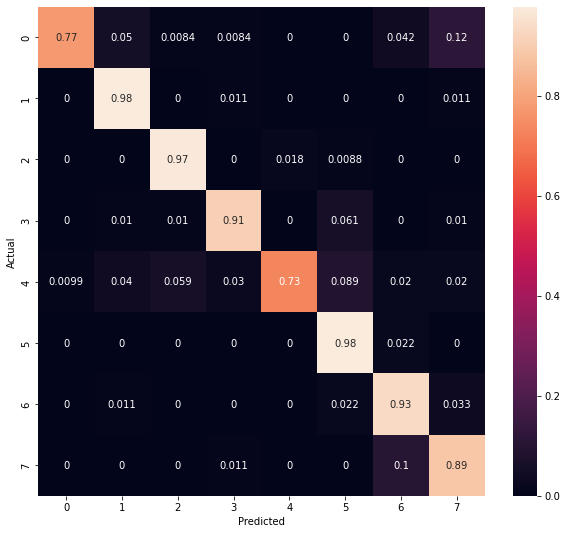

In [52]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, predictions, 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()